# Khushi Subgroup 4 - Bankruptcy Prediction Modeling.

## 1. Importing Libraries

In [1]:
print("Importing libraries")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully.\n")

Importing libraries
Libraries imported successfully.



## 2. Loading the Cluster 4 Data

In [2]:
df = pd.read_csv('df_cluster_4.csv')
print(f"Cluster 4 data shape: {df.shape}\n")
df.head(10)

Cluster 4 data shape: (1186, 31)



,ROA(C) before interest and depreciation before interest,Operating Expense Rate,Long-term Liability to Current Assets,Inventory/Current Liability,Total expense/Assets,Long-term fund suitability ratio (A),Inventory Turnover Rate (times),Current Asset Turnover Rate,Revenue per person,Research and development expense rate,...,Operating Gross Margin,Cash flow rate,Average Collection Days,Degree of Financial Leverage (DFL),Accounts Receivable Turnover,Net Value Growth Rate,Realized Sales Gross Profit Growth Rate,Cluster,Bankrupt?,Index
0,0.271154,-0.710131,-0.270475,-0.091866,0.933722,2.630791,1.220992,-0.470798,0.106299,-1.203466,...,0.672501,0.945211,-0.097120,-0.119558,-0.153165,-0.003172,-0.071502,4,0,9
1,-0.074437,-0.710025,-0.261282,0.185686,0.377035,0.156614,1.064739,-0.470301,-1.467446,-1.203455,...,2.496470,-0.544932,-0.308210,0.064418,-0.114092,1.519756,-0.040943,4,0,14
2,-0.351847,-0.710112,-0.270475,-0.123686,0.380794,-0.241325,-0.862116,-0.470802,-0.656034,-1.203463,...,0.617445,0.094899,0.251546,-0.119558,-0.191145,-0.151131,-0.071768,4,0,17
3,-0.027826,-0.710138,-0.270475,-0.089767,0.812197,-0.070407,1.220372,-0.470891,-0.515162,-1.203472,...,0.866052,0.483440,-0.271413,-0.115045,-0.122260,-0.079203,-0.080136,4,0,35
4,0.405393,-0.710162,-0.270475,-0.116450,0.562597,-0.640080,1.210143,-0.470868,0.392093,-1.203477,...,0.330922,0.027208,0.306025,-0.101199,-0.195406,-0.075601,-0.064658,4,0,39
5,-0.502686,-0.710160,-0.270475,-0.065443,0.243768,-0.370061,1.214276,-0.470834,-0.544902,-1.203478,...,-0.143270,-0.324854,-0.155056,0.062193,-0.144067,-0.146107,-0.050342,4,0,43
6,-1.094667,-0.710021,-0.270475,-0.055006,0.873883,1.323025,-0.862112,-0.470473,-1.316106,-1.203478,...,0.788694,-1.718717,0.330100,-0.119558,-0.197233,-0.183896,1.180723,4,0,51
7,-1.093115,-0.710090,-0.270475,0.002283,-0.233344,-0.578737,1.221128,-0.470585,-1.338579,-1.203479,...,-0.665511,-0.755186,0.183047,-0.123469,-0.185365,0.104976,0.698789,4,0,52
8,0.427413,-0.710143,-0.270475,-0.191490,0.607147,-0.299825,-0.862115,-0.470835,-0.737159,-1.203475,...,0.853899,0.105645,-0.265840,-0.111151,-0.123470,-0.077682,-0.052616,4,0,61
9,-1.284987,1.409128,-0.270475,3.611300,-1.412924,-0.082209,1.185535,-0.470849,0.240448,-1.203484,...,-1.350734,2.912489,-0.934229,-0.119861,0.531831,-0.220445,-0.291549,4,0,62


## 3. Preparing Features and Target

In [3]:
X = df.drop(columns=['Cluster', 'Bankrupt?', 'Index'])
y = df['Bankrupt?']
print(f"Number of features used: {X.shape[1]}\n")


Number of features used: 28



## 4. Selecting Top 10 Features

In [4]:
print("Selecting Top 10 Features")

# Temporary Random Forest for feature importance
temp_rf = RandomForestClassifier(n_estimators=100, random_state=42)
temp_rf.fit(X, y)

# Get top 10 important features
feature_importances = pd.Series(temp_rf.feature_importances_, index=X.columns)
top_10_features = feature_importances.sort_values(ascending=False).head(10).index.tolist()

print("Selected Top 10 Features:")
for i, feature in enumerate(top_10_features, 1):
    print(f"{i}. {feature}")

# Keep only top 10 features
X = X[top_10_features]
print(f"Shape after feature selection: {X.shape}\n")

Selecting Top 10 Features
Selected Top 10 Features:
1.  Net Value Growth Rate
2.  Total expense/Assets
3.  Total debt/Total net worth
4.  Current Ratio
5.  ROA(C) before interest and depreciation before interest
6.  Degree of Financial Leverage (DFL)
7.  Long-term fund suitability ratio (A)
8.  Realized Sales Gross Profit Growth Rate
9.  Revenue per person
10.  Current Liabilities/Liability
Shape after feature selection: (1186, 10)



## 5. Defining Base Models and Meta Model

### Why These Base Models and Stacking Model Were Chosen

- **Random Forest Classifier:**
  A powerful ensemble method based on decision trees. It reduces overfitting, handles high-dimensional data well,
  and provides feature importance, making it ideal for bankruptcy prediction tasks.

- **K-Nearest Neighbors (KNN):**
  A simple, instance-based learning algorithm that makes predictions based on proximity to neighboring data points.
  It is useful because it makes no assumptions about the underlying data distribution.

- **Gradient Boosting Classifier:**
  An ensemble technique that builds weak learners sequentially to correct errors from previous learners.
  It performs exceptionally well for structured tabular datasets and handles class imbalance with careful tuning.

**Meta-Model:**

- **Logistic Regression:**
  A simple yet effective linear classifier that combines the outputs from base models.
  Logistic regression avoids overfitting and provides strong generalization when using high-quality base model predictions.

In [5]:
print("Defining base models.")
base_models = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42, class_weight = 'balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42))
]


Defining base models.


In [6]:
# --- Meta Model ---
print("Defining meta model.")
meta_model = LogisticRegression(max_iter=1000, random_state=42 , class_weight = 'balanced')

# --- Build Stacking Model ---
print("Building stacking classifier")
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=10,
    n_jobs=-1,
    passthrough=True
)


Defining meta model.
Building stacking classifier


In [7]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## 7. Evaluating Models with Cross-Validation


 Confusion Matrices for Individual Base Models and Stacking Model 


Evaluating Random Forest.

Confusion Matrix:
[[1174    1]
 [  11    0]]
Custom Bankruptcy Detection Accuracy (acc = TT / (TF + TT)): 0.0000
Overall Accuracy: 0.9899


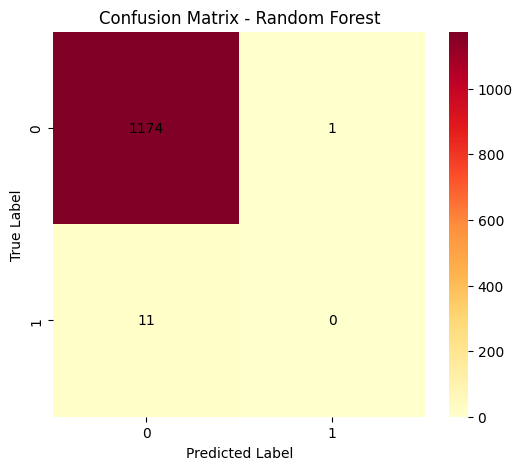


Evaluating KNN.

Confusion Matrix:
[[1175    0]
 [  11    0]]
Custom Bankruptcy Detection Accuracy (acc = TT / (TF + TT)): 0.0000
Overall Accuracy: 0.9907


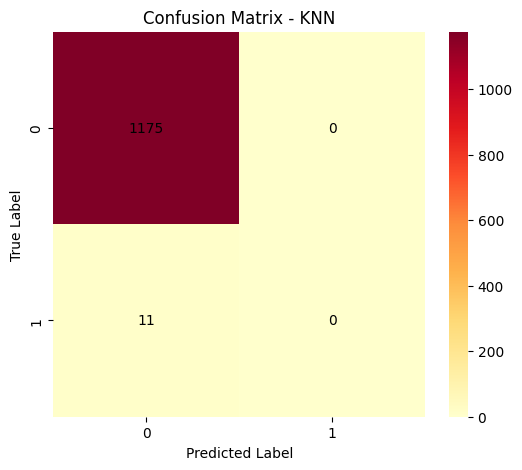


Evaluating Gradient Boosting.

Confusion Matrix:
[[1169    6]
 [   9    2]]
Custom Bankruptcy Detection Accuracy (acc = TT / (TF + TT)): 0.1818
Overall Accuracy: 0.9874


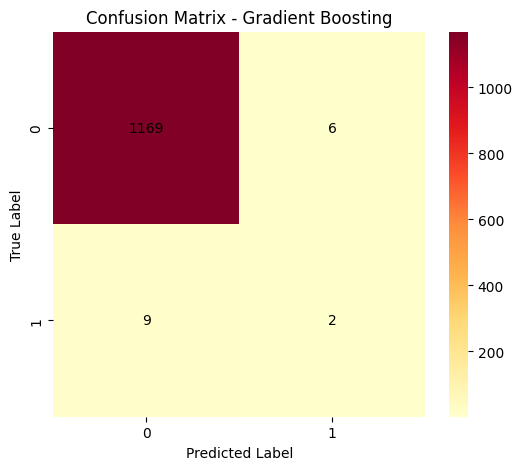


Evaluating Stacking.

Confusion Matrix:
[[1100   75]
 [   4    7]]
Custom Bankruptcy Detection Accuracy (acc = TT / (TF + TT)): 0.6364
Overall Accuracy: 0.9334


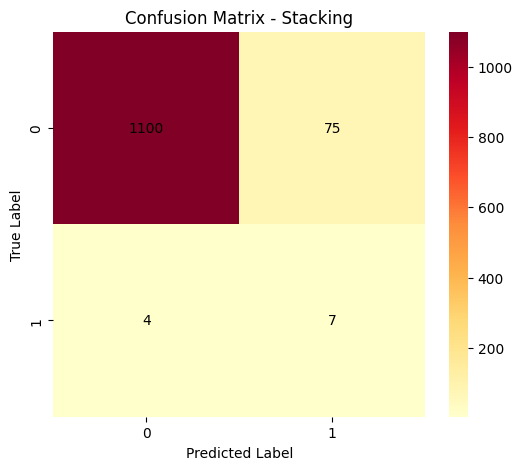

In [8]:
print("\n Confusion Matrices for Individual Base Models and Stacking Model \n")

models = {
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42),
    'Stacking': stacking_clf
}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}.")
    y_pred_model = cross_val_predict(model, X, y, cv=cv, method='predict')

    cm_model = confusion_matrix(y, y_pred_model)
    tn, fp, fn, tp = cm_model.ravel()

    # Custom bankruptcy detection accuracy
    if (tp + fn) > 0:
        acc_model = tp / (tp + fn)
    else:
        acc_model = 0.0

    print("\nConfusion Matrix:")
    print(cm_model)
    print(f"Custom Bankruptcy Detection Accuracy (acc = TT / (TF + TT)): {acc_model:.4f}")
 
    # Overall accuracy 
    overall_accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_model,
                annot=True, 
                fmt='d', 
                cmap='YlOrRd',
                annot_kws={"color": "black"})
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## 10. Visualizing Prediction Distribution


Performing 10-Fold Cross Validation for Stacking Model.

Counting bankruptcy predictions for Cluster 4...
Total companies in Cluster 4: 1186
Predicted Bankrupt (1): 82
Predicted Not Bankrupt (0): 1104


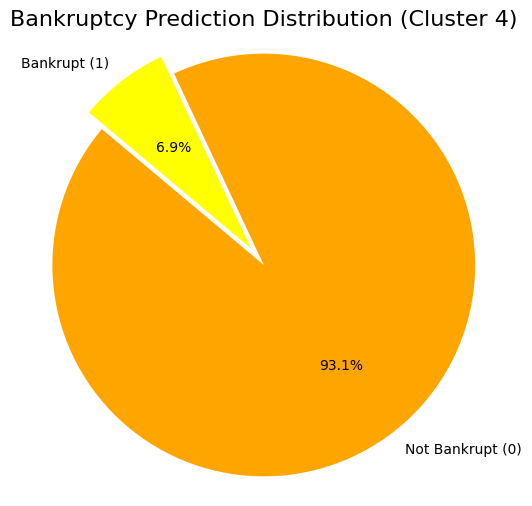

In [9]:
print("\nPerforming 10-Fold Cross Validation for Stacking Model.")
y_pred = cross_val_predict(stacking_clf, X, y, cv=cv, method='predict')

#  Pie Chart for Prediction Distribution 
print("\nCounting bankruptcy predictions for Cluster 4...")
predicted_bankrupt = np.sum(y_pred == 1)
predicted_not_bankrupt = np.sum(y_pred == 0)

print(f"Total companies in Cluster 4: {len(y_pred)}")
print(f"Predicted Bankrupt (1): {predicted_bankrupt}")
print(f"Predicted Not Bankrupt (0): {predicted_not_bankrupt}")

plt.figure(figsize=(6,6))
labels = ['Not Bankrupt (0)', 'Bankrupt (1)']
sizes = [predicted_not_bankrupt, predicted_bankrupt]
palette = ['orange','yellow']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, 
        labels=labels, 
        colors=palette, 
        autopct='%1.1f%%',
        startangle=140)
plt.title('Bankruptcy Prediction Distribution (Cluster 4)', fontsize=16)
plt.axis('equal')
plt.show()

## 11. Classification Report


Generating confusion matrix for Stacking Classifier.

Confusion Matrix:
[[1100   75]
 [   4    7]]

Calculating custom bankruptcy detection accuracy.

Custom Bankruptcy Detection Accuracy (acc = TT / (TF + TT)): 0.6364
Overall Accuracy: 0.9334

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1175
           1       0.09      0.64      0.15        11

    accuracy                           0.93      1186
   macro avg       0.54      0.79      0.56      1186
weighted avg       0.99      0.93      0.96      1186



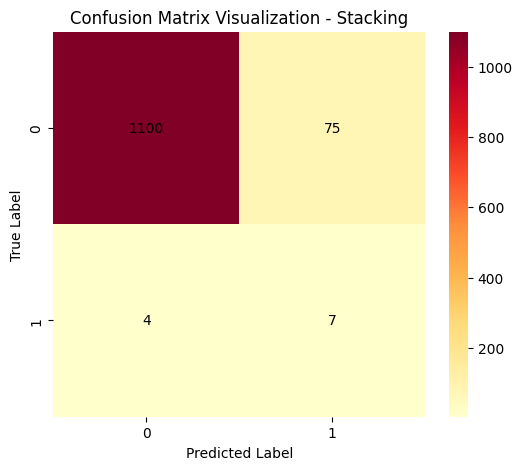

In [10]:
print("\nGenerating confusion matrix for Stacking Classifier.")
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix:")
print(cm)

#  Bankruptcy Detection Accuracy 
print("\nCalculating custom bankruptcy detection accuracy.")
if (tp + fn) > 0:
    acc = tp / (tp + fn)
else:
    acc = 0.0
print(f"\nCustom Bankruptcy Detection Accuracy (acc = TT / (TF + TT)): {acc:.4f}")
overall_accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Classification Report 
print("\nClassification Report:")
print(classification_report(y, y_pred))

#  Visualize Confusion Matrix 
plt.figure(figsize=(6,5))
sns.heatmap(cm_model, 
            annot=True, 
            fmt='d', 
            cmap='YlOrRd',
            annot_kws={"color": "black"},
            )
plt.title('Confusion Matrix Visualization - Stacking')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 8. Full Training on Entire Cluster 3 Data


Training stacking model fully on the entire cluster 3 data

Plotting feature importances from Random Forest base model


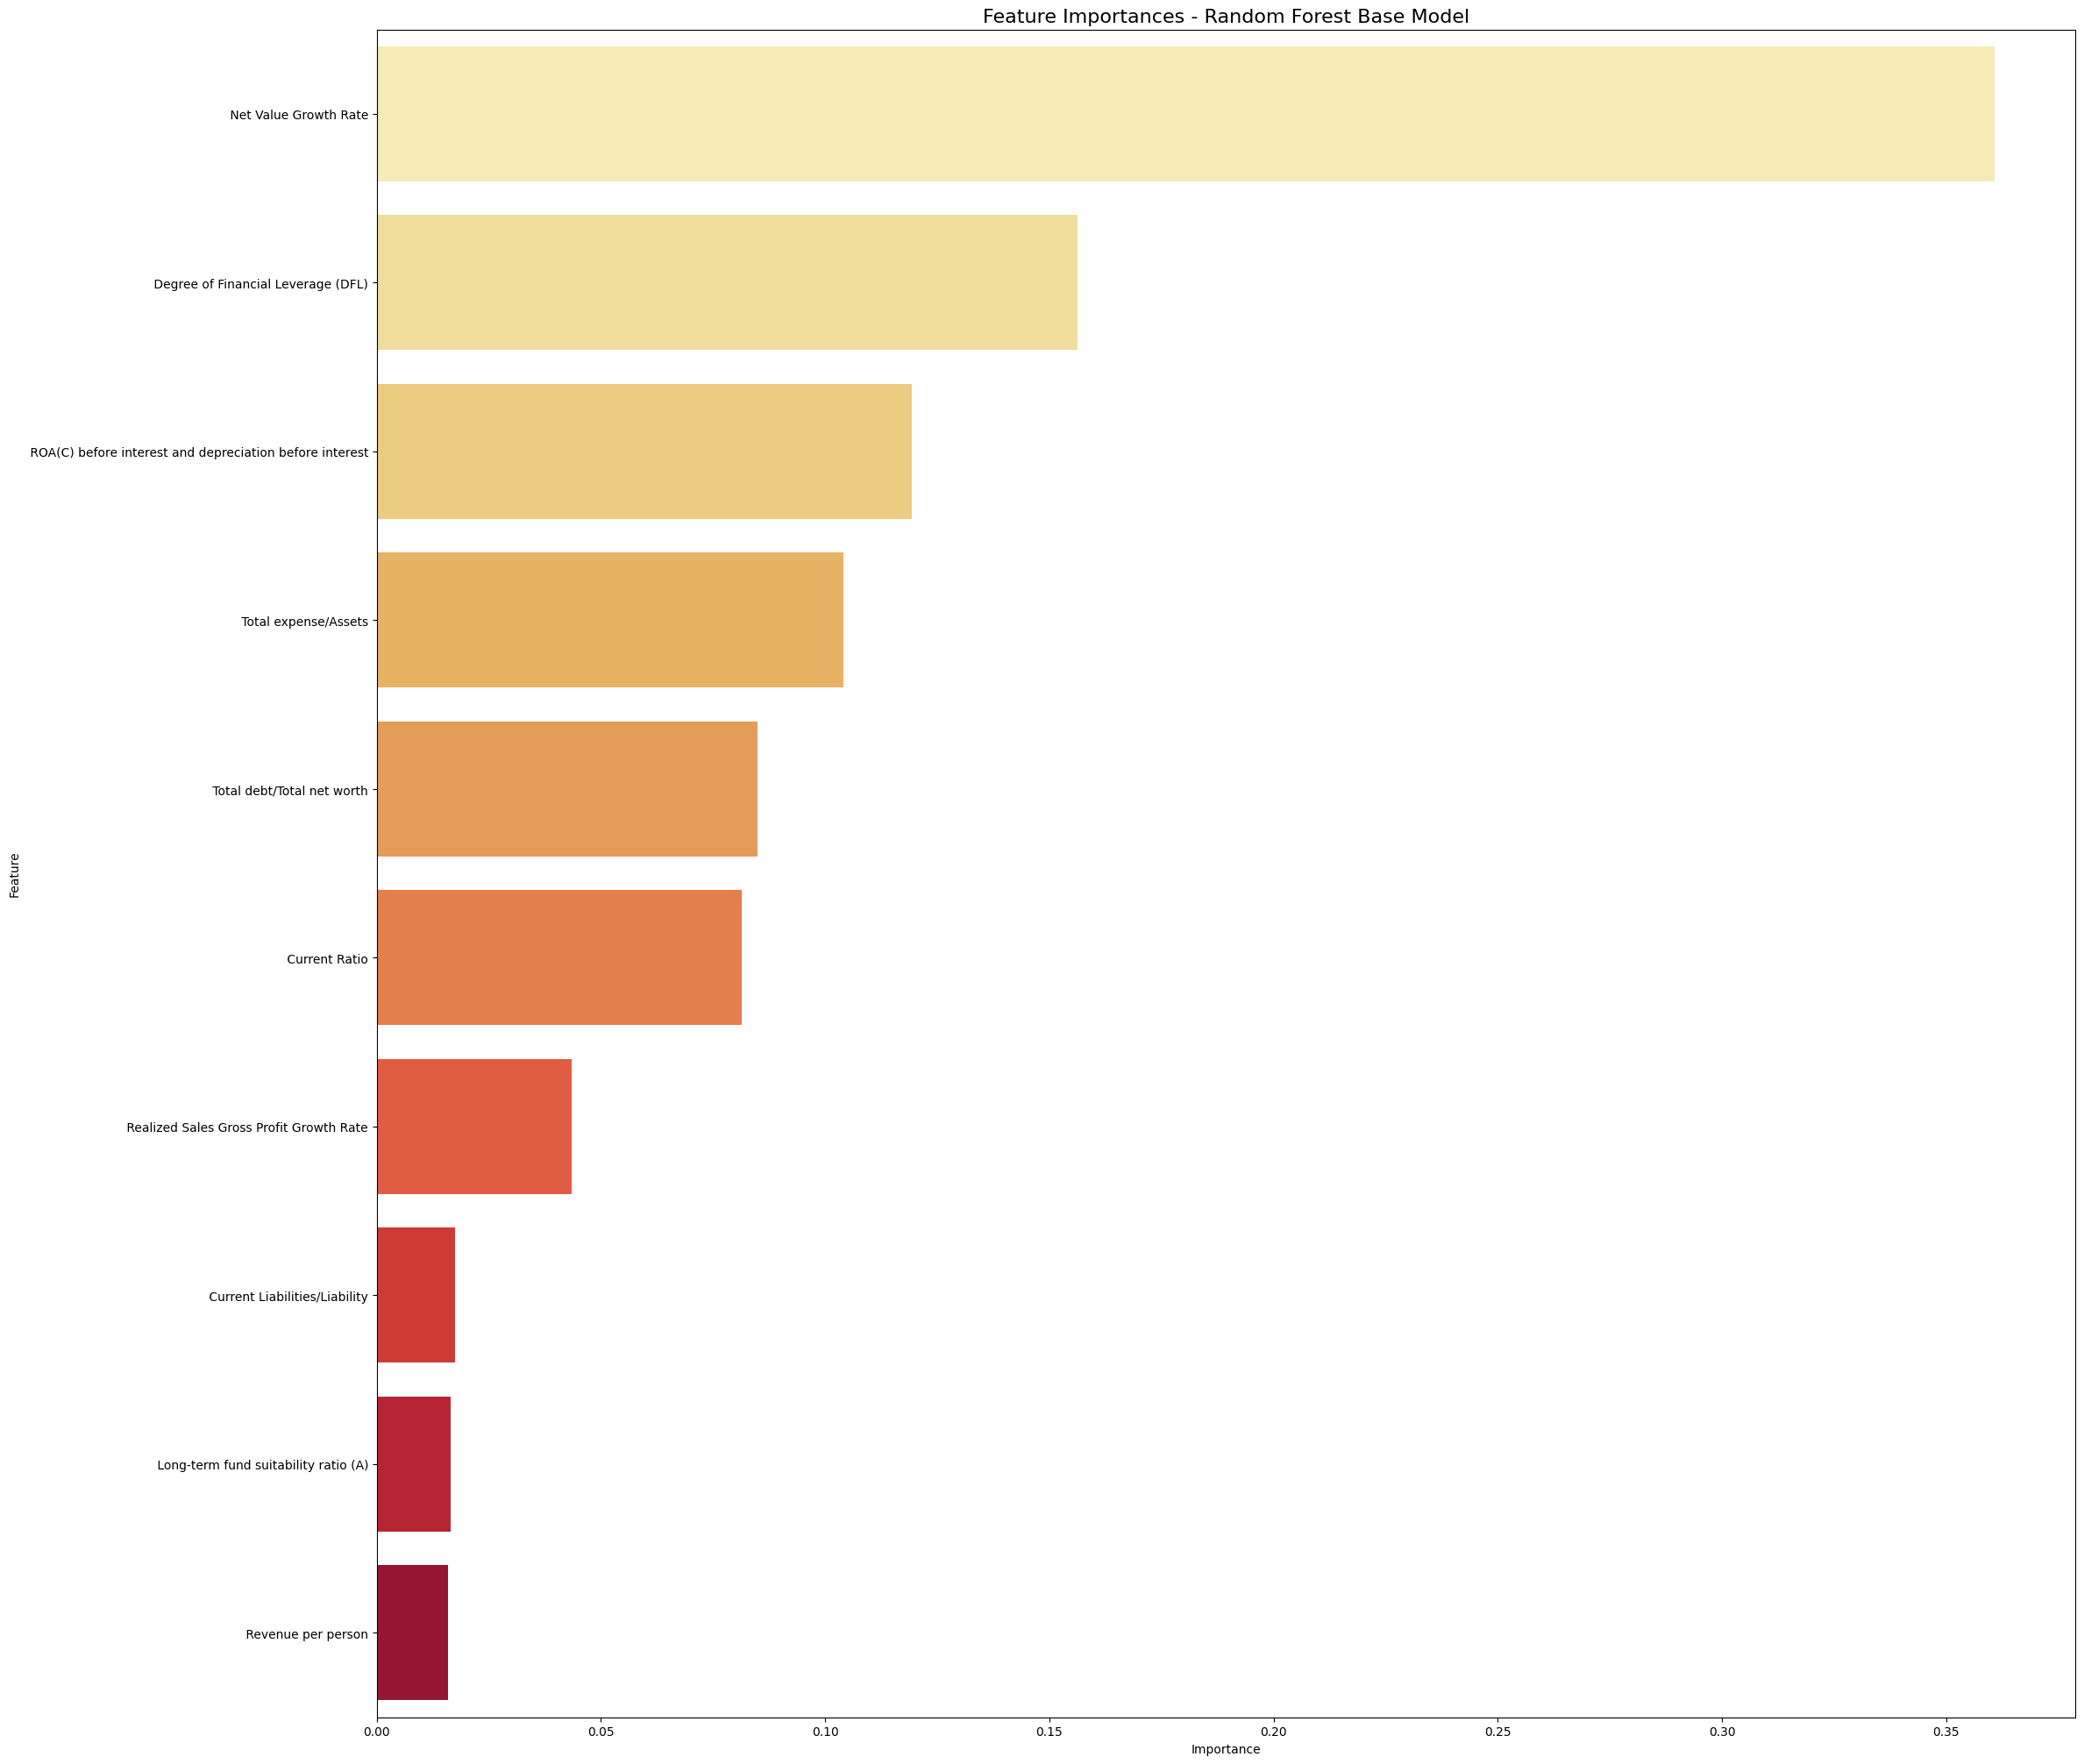

In [11]:
print("\nTraining stacking model fully on the entire cluster 3 data")
stacking_clf.fit(X, y)

#  Feature Importance from Random Forest Base Model 
print("\nPlotting feature importances from Random Forest base model")
rf_model = stacking_clf.named_estimators_['rf']
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(25,25))
sns.barplot(x=importances, 
            y=importances.index , 
            palette='YlOrRd',
            orient = 'h')
plt.title('Feature Importances - Random Forest Base Model', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 13. Saving Final Stacking Model

In [12]:
print("\nSaving final stacking model...")
joblib.dump(stacking_clf, 'khushi_cluster4_stacking_model.joblib')
print("Model saved successfully as 'khushi_cluster4_stacking_model.joblib'.")


Saving final stacking model...
Model saved successfully as 'khushi_cluster4_stacking_model.joblib'.


## 14. Final cluster 4 Report 

In [13]:
# Final Project Report with Overall Accuracy 

# Prepare list of base model names
base_specs = {
    'rf': 'Random Forest Classifier',
    'knn': 'K-Nearest Neighbors Classifier',
    'gb': 'Gradient Boosting Classifier'
}

# Top 10 features selected
top10 = top_10_features

# Custom accuracies
acc_meta = tp / (tp + fn) if (tp + fn) > 0 else 0.0
overall_acc = (tp + tn) / (tp + tn + fp + fn)

# Report dictionary
report = {
    'Member':        'Khushi',
    'Cluster':       4,
    'TT_meta':       int(tp),
    'TF_meta':       int(fn),
    'acc_meta':      round(acc_meta, 4),
    'overall_acc':   round(overall_acc, 4),
    'N_features':    X.shape[1],
    'Base_models':   list(base_specs.values()), 
    'Top10_features': top10
}

# Print report
print("\nFinal Report for Cluster 4:")
for k, v in report.items():
    print(f"{k}: {v}")



Final Report for Cluster 4:
Member: Khushi
Cluster: 4
TT_meta: 7
TF_meta: 4
acc_meta: 0.6364
overall_acc: 0.9334
N_features: 10
Base_models: ['Random Forest Classifier', 'K-Nearest Neighbors Classifier', 'Gradient Boosting Classifier']
Top10_features: [' Net Value Growth Rate', ' Total expense/Assets', ' Total debt/Total net worth', ' Current Ratio', ' ROA(C) before interest and depreciation before interest', ' Degree of Financial Leverage (DFL)', ' Long-term fund suitability ratio (A)', ' Realized Sales Gross Profit Growth Rate', ' Revenue per person', ' Current Liabilities/Liability']
